#Quark Gluon notebook

## import libraries

In [ ]:
import os
# Set TensorFlow logging to only show errors
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # This silences INFO and WARNING messages
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import h5py
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Add, Dense, Dropout, Embedding, GlobalAveragePooling1D, Input, Layer, LayerNormalization, MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

try:
  import pennylane as qml
except:
  !pip install pennylane
  import pennylane as qml
from pennylane.operation import Operation

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 35.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 714.0 kB/s eta 0:00:00


## Import the dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the file paths
file_path = '/content/drive/MyDrive/quark-gluon-dataset/quark-gluon_train-set_n793900.hdf5'

# Set a seed for reproducibility
np.random.seed(42)  # You can use any integer as the seed

# Function to inspect the contents of the HDF5 file
def inspect_hdf5_file(file_path):
    with h5py.File(file_path, 'r') as hdf_file:
        print("Contents of the HDF5 file:")
        hdf_file.visititems(lambda name, obj: print(name))

# Inspect the contents of the HDF5 file
inspect_hdf5_file(file_path)

# Function to load only the first 20k samples from an HDF5 file
def load_partial_data_from_hdf5(file_path, max_samples=10000):
    with h5py.File(file_path, 'r') as hdf_file:
        X_data = np.array(hdf_file['X_jets'][:max_samples])
        y_data = np.array(hdf_file['y'][:max_samples])
    return X_data, y_data

# Load the first 20k samples of datasets
X, y = load_partial_data_from_hdf5(file_path, max_samples=10000)

# Print the shapes of the loaded data
print(f'Data shape: X={X.shape}, y={y.shape}')


# Shuffle the dataset
indices = np.arange(X.shape[0])
np.random.shuffle(indices)
X = X[indices]
y = y[indices]

# Print the shapes of the loaded and shuffled data
print(f'Data shape: X={X.shape}, y={y.shape}')

Contents of the HDF5 file:
X_jets
m0
pt
y
Data shape: X=(10000, 125, 125, 3), y=(10000,)
Data shape: X=(10000, 125, 125, 3), y=(10000,)


In [ ]:
# 70% of the data for training and 15% for testing and validation
split_index_1 = int(0.7 * X.shape[0])
split_index_2 = int(0.85 * X.shape[0])

train_images, test_images, validation_images = X[:split_index_1], X[split_index_1:split_index_2], X[split_index_2:]
train_labels, test_labels, validation_labels = y[:split_index_1], y[split_index_1:split_index_2], y[split_index_2:]
del X
del y

In [ ]:
def plot_images(images, labels, num_images=25, figsize=(10,10)):
    # Compute the grid size needed (square root of num_images, rounded up)
    grid_size = 5

    # Set up the figure
    plt.figure(figsize=figsize)

    for i in range(num_images):
        plt.subplot(grid_size, grid_size, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i,:,:,0], cmap='gray')
        plt.xlabel(f'Label: {labels[i]}')
    plt.show()

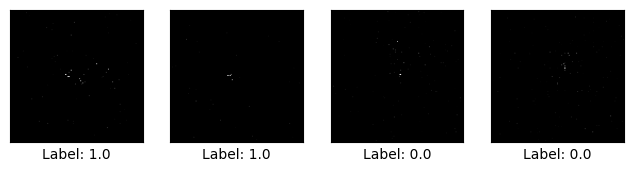

In [ ]:
#Plot some of the images with their labels
plot_images(train_images, train_labels, num_images=4, figsize=(10,10))

## Common Transformer components

In [ ]:
class PatchExtractor(Layer):
    def __init__(self, patch_size=25):
        super(PatchExtractor, self).__init__()
        self.patch_size = patch_size  # Initialize patch size

    def call(self, images):
        # Calculate the batch size from the images tensor
        batch_size = tf.shape(images)[0]
        # Extract patches from images
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],  # Size of patches to extract
            strides=[1, self.patch_size, self.patch_size, 1],  # Stride for each patch
            rates=[1, 1, 1, 1],  # Dilation rate, set to 1 meaning no dilation
            padding="VALID",  # Use valid padding, no padding is applied
        )
        # Reshape the patches to have the patch dimension flattened
        patches = tf.reshape(patches, [batch_size, -1, patches.shape[-1]])
        return patches

In [ ]:
image = train_images[0]  # Select the first image of the dataset
batch = tf.expand_dims(image, 0)  # Adds the batch dimension

# Now use PatchExtractor
patches = PatchExtractor(patch_size=25)(batch)

patches.shape

TensorShape([1, 25, 1875])

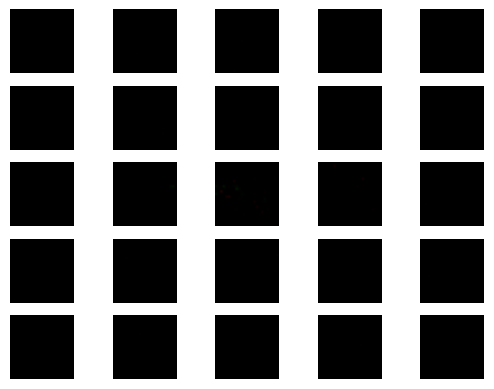

In [ ]:
# Calculate the number of patches per side (sqrt) to organize the subplot grid
n = int(np.sqrt(patches.shape[1]))

# Visualize each patch
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    # Since the patch is flattened, we reshape it back to its original size (4x4 here), and there's only one channel for grayscale
    patch_img = tf.reshape(patch, (25, 25, 3))
    patch_img = patch_img[:,:,:]
    ax.imshow(patch_img.numpy())
    ax.axis("off")

plt.show()

In [ ]:
class PatchEncoder(Layer):
    def __init__(self, num_patches=25, projection_dim=8):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches  # Total number of patches
        self.projection_dim = projection_dim  # Dimension to project each patch onto
        # Initialize weights for the class token
        w_init = tf.random_normal_initializer()
        self.class_token = tf.Variable(initial_value=w_init(shape=(1, projection_dim), dtype="float32"), trainable=True)
        self.projection = Dense(units=projection_dim)  # Dense layer to project patch features
        self.position_embedding = Embedding(input_dim=num_patches + 1, output_dim=projection_dim)  # Positional embeddings

    def call(self, patches):
        batch_size = tf.shape(patches)[0]  # Calculate the batch size
        # Repeat the class token for each item in the batch
        class_token = tf.tile(self.class_token, multiples=[batch_size, 1])
        class_token = tf.reshape(class_token, (batch_size, 1, self.projection_dim))
        # Project the patches to the specified dimension
        patches_embed = self.projection(patches)
        # Concatenate the class token with the projected patches
        patches_embed = tf.concat([class_token, patches_embed], axis=1)
        # Calculate positional embeddings for all patches + class token
        positions = tf.range(start=0, limit=self.num_patches + 1, delta=1)
        positions_embed = self.position_embedding(positions)
        # Add positional embeddings to the concatenated embeddings
        encoded = patches_embed + positions_embed
        return encoded

In [ ]:
embeddings = PatchEncoder()(patches)
embeddings.shape

TensorShape([1, 26, 8])

In [ ]:
class MLP(Layer):
    def __init__(self, hidden_features, out_features, dropout_rate=0.1):
        super(MLP, self).__init__()
        # First dense layer with GELU activation
        self.dense1 = Dense(hidden_features, activation=tf.nn.gelu)
        # Second dense layer for output features
        self.dense2 = Dense(out_features)
        # Dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Apply first dense layer
        x = self.dense1(x)
        # Apply dropout
        x = self.dropout(x)
        # Apply second dense layer
        x = self.dense2(x)
        # Apply dropout again
        y = self.dropout(x)
        return y

mlp = MLP(64, 16)
y = mlp(tf.zeros((1, 17, 6)))
y.shape

TensorShape([1, 17, 16])

## Common Quantum functions

In [ ]:
class RBSGate(Operation):
    num_params = 1
    num_wires = 2
    par_domain = 'R'

    def __init__(self, theta, wires):
        super().__init__(theta, wires=wires)
        self.theta = theta

    @staticmethod
    def compute_matrix(theta):
        cos = tf.cos(theta)
        sin = tf.sin(theta)
        return tf.convert_to_tensor([
            [1, 0, 0, 0],
            [0, cos, sin, 0],
            [0, -sin, cos, 0],
            [0, 0, 0, 1]
        ], dtype=tf.float64)

    def adjoint(self):
        return RBSGate(-self.parameters[0], wires=self.wires)

    def label(self, decimals=None, base_label=None, **kwargs):
        theta = self.parameters[0]
        return f"RBS({theta:.2f})"

In [ ]:
def convert_array(X):
    alphas = tf.zeros(X.shape[:-1] + (X.shape[-1]-1,), dtype=X.dtype)
    X_normd = tf.linalg.l2_normalize(X, axis=-1)
    for i in range(X.shape[-1]-1):
        prod_sin_alphas = tf.reduce_prod(tf.sin(alphas[..., :i]), axis=-1)
        updated_value = tf.acos(X_normd[..., i] / prod_sin_alphas)
        indices = tf.constant([[i]])
        updates = tf.reshape(updated_value, [1])
        alphas = tf.tensor_scatter_nd_update(alphas, indices, updates)
    return alphas

In [ ]:
def vector_loader(alphas, wires=None, is_x=True, is_conjugate=False):
    if wires is None:
        wires = list(range(len(alphas) + 1))
    if is_x and not is_conjugate:
        qml.PauliX(wires=wires[0])
    if is_conjugate:
        for i in range(len(wires) - 2, -1, -1):
            qml.apply(RBSGate(-alphas[i], wires=[wires[i], wires[i+1]]))
    else:
        for i in range(len(wires) - 1):
            qml.apply(RBSGate(alphas[i], wires=[wires[i], wires[i+1]]))
    if is_x and is_conjugate:
        qml.PauliX(wires=wires[0])

In [ ]:
def pyramid_circuit(parameters, wires=None):
    if wires is None:
        length = len(qml.device.wires)
    else:
        length = len(wires)

    k = 0

    for i in range(2 * length - 2):
        j = length - abs(length - 1 - i)

        if i % 2:
            for _ in range(j):
                if _ % 2 == 0 and k < len(parameters):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1
        else:
            for _ in range(j):
                if _ % 2 and k < len(parameters):
                    qml.apply(RBSGate(parameters[k], wires=([wires[_], wires[_ + 1]])))
                    k += 1

## Classical transformer

In [ ]:
class Block(Layer):
    def __init__(self, projection_dim, num_heads=1, dropout_rate=0.2):
        super(Block, self).__init__()
        # First layer normalization
        self.norm1 = LayerNormalization(epsilon=1e-6)
        # Multi-head attention layer
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=dropout_rate)
        # Second layer normalization
        self.norm2 = LayerNormalization(epsilon=1e-6)
        # MLP for further processing
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        # Apply first layer normalization
        x1 = self.norm1(x)
        # Apply multi-head attention
        attention_output = self.attn(x1, x1)
        # Add residual connection after attention
        x2 = Add()([attention_output, x])
        # Apply second layer normalization
        x3 = self.norm2(x2)
        # Apply MLP
        x3 = self.mlp(x3)
        # Add residual connection after MLP
        y = Add()([x3, x2])
        return y

block = Block(8)
y = block(tf.zeros((1, 17, 8)))
y.shape

TensorShape([1, 17, 8])

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_heads=1, num_blocks=1, dropout_rate=0.2):
        super(TransformerEncoder, self).__init__()
        # Define blocks of transformer encoder
        self.blocks = [Block(projection_dim, num_heads, dropout_rate) for _ in range(num_blocks)]
        # Final layer normalization
        self.norm = LayerNormalization(epsilon=1e-6)
        # Final dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Pass input through each block
        for block in self.blocks:
            x = block(x)
        # Apply final layer normalization
        x = self.norm(x)
        # Apply final dropout
        y = self.dropout(x)
        return y

transformer = TransformerEncoder(8)
y = transformer(embeddings)
y.shape

TensorShape([1, 26, 8])

In [ ]:
def create_VisionTransformer(num_patches=25, projection_dim=8, input_shape=(125,125,3)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Dense(1, activation='sigmoid')(representation)
    # Create model
    model = Model(inputs=inputs, outputs=logits)
    return model
model = create_VisionTransformer()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 patch_extractor_1 (PatchEx  (None, None, 1875)        0         
 tractor)                                                        
                                                                 
 patch_encoder_1 (PatchEnco  (None, 26, 8)             15224     
 der)                                                            
                                                                 
 transformer_encoder_1 (Tra  (None, 26, 8)             616       
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d (  (None, 8)                 0         
 GlobalAveragePooling1D)                                     

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Default learning rate for Adam is 0.001
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Add AUC to the list of metrics
)

In [ ]:
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/20
219/219 [==============================] - 6s 14ms/step - loss: 0.6983 - accuracy: 0.5209 - auc: 0.5275 - val_loss: 0.6794 - val_accuracy: 0.5147 - val_auc: 0.6575
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.6615 - accuracy: 0.6099 - auc: 0.6452 - val_loss: 0.6366 - val_accuracy: 0.6453 - val_auc: 0.6873
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.6080 - accuracy: 0.6889 - auc: 0.7299 - val_loss: 0.6453 - val_accuracy: 0.6533 - val_auc: 0.6925
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.5725 - accuracy: 0.7263 - auc: 0.7685 - val_loss: 0.6864 - val_accuracy: 0.6327 - val_auc: 0.7010
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.5333 - accuracy: 0.7617 - auc: 0.8020 - val_loss: 0.7423 - val_accuracy: 0.6360 - val_auc: 0.7043
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.4981 - accuracy: 0.7856 - auc: 0.8311 - val_loss

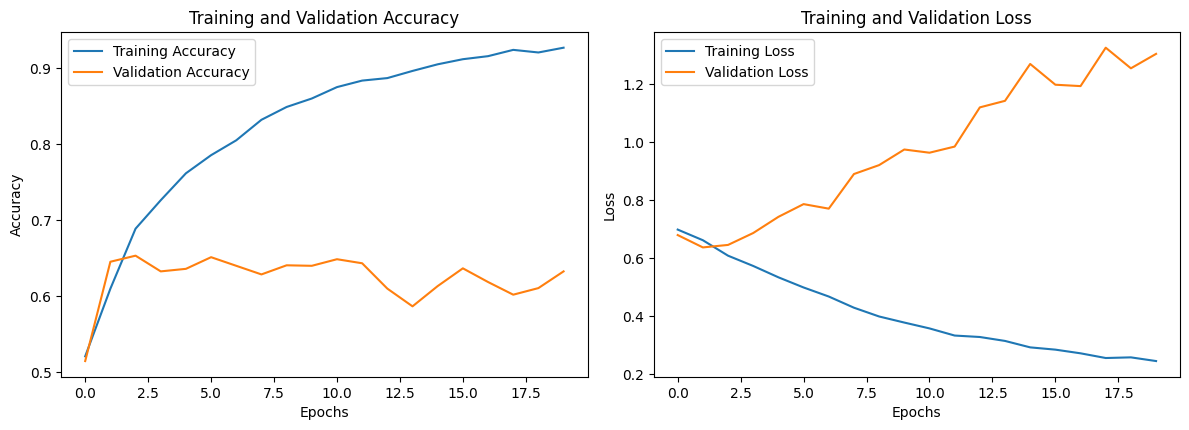

In [ ]:
# Plotting function
def plot_training_history(history):
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_training_history(history)

In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

47/47 [==============================] - 0s 4ms/step - loss: 1.3023 - accuracy: 0.6327 - auc: 0.6190
Test Loss: 1.302250862121582
Test Accuracy: 0.6326666474342346
Test AUC: 0.6189743280410767


## Quantum neural network

In [ ]:
class HybridModel(tf.keras.Model):
    def __init__(self):
        super(HybridModel, self).__init__()
        self.flatten = tf.keras.layers.Flatten()
        self.dense = tf.keras.layers.Dense(6, activation='linear', dtype=tf.float64)
        # Inizializzazione dei pesi quantistici
        self.quantum_weights = self.add_weight(
            shape=(15,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float32
        )
        # Definizione del circuito quantistico
        self.dev = qml.device('default.qubit.tf', wires=6)

        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(6))
            pyramid_circuit(weights, wires=range(6))
            return [qml.expval(qml.PauliZ(wire)) for wire in range(6)]

        self.quantum_circuit = quantum_circuit
        self.classical_nn_1 = tf.keras.layers.Dense(6, activation='relu', dtype=tf.float64)
        self.classical_nn_2 = tf.keras.layers.Dense(1, activation='sigmoid', dtype=tf.float64)

    def call(self, inputs):
        inputs = tf.cast(inputs, tf.float64)
        flattened_inputs = self.flatten(inputs)
        classical_output = self.dense(flattened_inputs)
        quantum_outputs = tf.map_fn(
            lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
            classical_output,
            fn_output_signature=tf.TensorSpec(shape=(6,), dtype=tf.float64)
        )
        # Handle NaN values in quantum outputs
        quantum_outputs = tf.where(tf.math.is_nan(quantum_outputs), tf.zeros_like(quantum_outputs), quantum_outputs)

        # Combine and process quantum outputs through additional NN layers
        quantum_outputs = tf.reshape(quantum_outputs, [-1, 6])
        nn_output = self.classical_nn_1(quantum_outputs)
        nn_output = self.classical_nn_2(nn_output)

        return nn_output
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Sanitize gradients: replace NaNs with zeros
        sanitized_gradients = []
        for grad in gradients:
            if grad is not None:
                # Replace NaNs with zeros
                grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            sanitized_gradients.append(grad)

        # Apply the sanitized gradients
        self.optimizer.apply_gradients(zip(sanitized_gradients, self.trainable_variables))

        #make weights that are nan 0
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}

In [ ]:
model = HybridModel()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]
)

# Start training
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/20


219/219 [==============================] - 45s 82ms/step - loss: 0.6588 - accuracy: 0.6189 - auc: 0.6613 - val_loss: 0.6316 - val_accuracy: 0.6507 - val_auc: 0.6961
Epoch 2/20
219/219 [==============================] - 14s 63ms/step - loss: 0.4733 - accuracy: 0.8000 - auc: 0.8652 - val_loss: 0.6983 - val_accuracy: 0.6320 - val_auc: 0.6737
Epoch 3/20
219/219 [==============================] - 14s 62ms/step - loss: 0.2457 - accuracy: 0.9230 - auc: 0.9643 - val_loss: 0.8357 - val_accuracy: 0.6467 - val_auc: 0.6876
Epoch 4/20
219/219 [==============================] - 14s 64ms/step - loss: 0.1200 - accuracy: 0.9660 - auc: 0.9903 - val_loss: 0.9750 - val_accuracy: 0.6460 - val_auc: 0.6855
Epoch 5/20
219/219 [==============================] - 14s 66ms/step - loss: 0.0619 - accuracy: 0.9833 - auc: 0.9972 - val_loss: 1.1191 - val_accuracy: 0.6327 - val_auc: 0.6753
Epoch 6/20
219/219 [==============================] - 14s 65ms/step - loss: 0.0313 - accuracy: 0.9929 - auc: 0.9993 - val_loss: 1.2

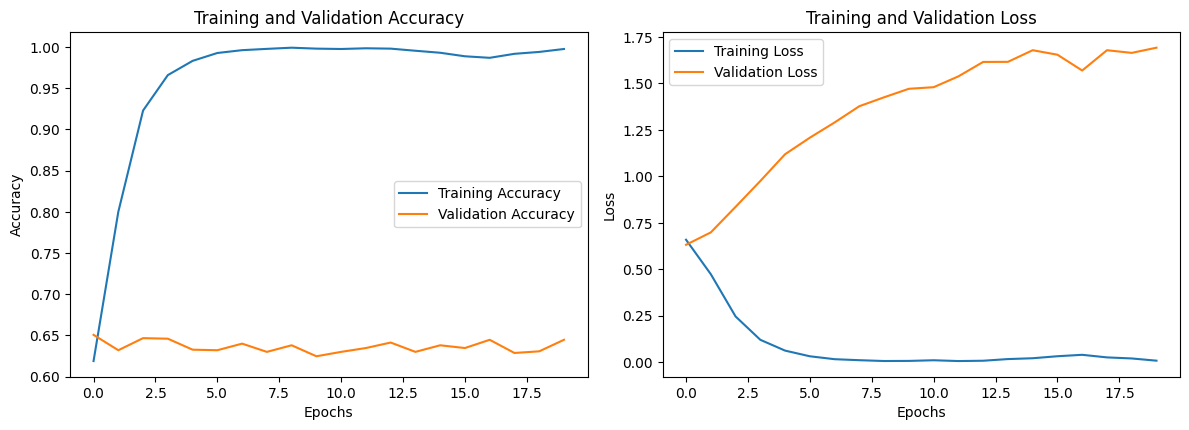

In [ ]:
# Plotting function
def plot_training_history(history):
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_training_history(history)

In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

47/47 [==============================] - 1s 14ms/step - loss: 1.6620 - accuracy: 0.6387 - auc: 0.6815
Test Loss: 1.661981463432312
Test Accuracy: 0.6386666893959045
Test AUC: 0.6815396547317505


## Quantum Patch-wise Transformer

In [ ]:
class QuantumSelfAttentionHead(Layer):
    def __init__(self, d_model):
        super(QuantumSelfAttentionHead, self).__init__()
        self.d_model = d_model
        self.n_qubits = d_model  # Number of qubits equals the model dimension

        # Define the quantum device
        self.dev = qml.device("default.qubit.tf", wires=self.n_qubits)

        # Initialize quantum weights (float32 as in your HybridModel)
        self.quantum_weights = self.add_weight(
            shape=(self.d_model * (self.d_model - 1) // 2,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float32,
            name='quantum_weights'
        )

        # Define the quantum circuit as a QNode
        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_circuit(inputs, weights):
            inputs = tf.cast(inputs, tf.float32)
            weights = tf.cast(weights, tf.float32)
            vector_loader(convert_array(inputs), wires=range(self.n_qubits))
            pyramid_circuit(weights, wires=range(self.n_qubits))
            # Return expectation values as float64 (default)
            return [qml.expval(qml.PauliZ(wire)) for wire in range(self.n_qubits)]

        self.quantum_circuit = quantum_circuit

    def call(self, patches):
        """
        Processes each patch through the quantum circuit.

        Args:
            patches (Tensor): Tensor of shape (batch_size, num_patches, d_model).

        Returns:
            Tensor: New patch embeddings after quantum processing, shape (batch_size, num_patches, d_model).
        """
        # Reshape patches to (batch_size * num_patches, d_model)
        batch_size = tf.shape(patches)[0]
        num_patches = tf.shape(patches)[1]
        patch_dim = tf.shape(patches)[2]
        patches_reshaped = tf.reshape(patches, (-1, patch_dim))  # Shape: (batch_size * num_patches, d_model)

        # Ensure the patch_dim matches the number of qubits
        assert_op = tf.debugging.assert_equal(
            patch_dim, self.n_qubits,
            message=f"Patch dimension ({patch_dim}) must equal number of qubits ({self.n_qubits})"
        )
        with tf.control_dependencies([assert_op]):
            # Apply the quantum circuit to each patch
            quantum_outputs = tf.map_fn(
                lambda x: tf.stack(self.quantum_circuit(x, self.quantum_weights)),
                patches_reshaped,
                fn_output_signature=tf.TensorSpec(shape=(self.n_qubits,), dtype=tf.float64)
            )

        # Reshape back to (batch_size, num_patches, d_model)
        quantum_outputs = tf.reshape(quantum_outputs, (batch_size, num_patches, self.d_model))

        return quantum_outputs  # No additional projection needed

In [ ]:
class Block(Layer):
    def __init__(self, projection_dim, dropout_rate=0.1):
        """
        Initializes the Transformer Block with Quantum Self-Attention.

        Args:
            projection_dim (int): Dimension of the projection (should match d_model).
            dropout_rate (float): Dropout rate to apply after layers.
        """
        super(Block, self).__init__()
        # First layer normalization (float64)
        self.norm1 = LayerNormalization(epsilon=1e-6, dtype=tf.float64)
        # Quantum Self-Attention Head
        self.attn = QuantumSelfAttentionHead(d_model=projection_dim)
        # Second layer normalization (float64)
        self.norm2 = LayerNormalization(epsilon=1e-6, dtype=tf.float64)
        # MLP for further processing
        self.mlp = MLP(projection_dim * 2, projection_dim, dropout_rate)

    def call(self, x):
        """
        Forward pass for the Transformer Block.

        Args:
            x (Tensor): Input tensor of shape (batch_size, num_patches + 1, projection_dim).

        Returns:
            Tensor: Output tensor of the same shape as input.
        """
        # Apply first layer normalization
        x1 = self.norm1(x)
        # Apply Quantum Self-Attention
        attention_output = self.attn(x1)
        # Add residual connection
        x2 = Add()([attention_output, x])
        # Apply second layer normalization
        x3 = self.norm2(x2)
        # Apply MLP
        x3 = self.mlp(x3)
        # Add residual connection
        y = Add()([x3, x2])
        return y

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_blocks=1, dropout_rate=0.2):
        super(TransformerEncoder, self).__init__()
        # Define blocks of transformer encoder
        self.blocks = [Block(projection_dim, dropout_rate) for _ in range(num_blocks)]
        # Final layer normalization
        self.norm = LayerNormalization(epsilon=1e-6)
        # Final dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Pass input through each block
        for block in self.blocks:
            x = block(x)
        # Apply final layer normalization
        x = self.norm(x)
        # Apply final dropout
        y = self.dropout(x)
        return y

In [ ]:
# Define the QuantumSelfAttentionVisionTransformer class with the updated train_step needed to handle nan values
class QuantumSelfAttentionVisionTransformer(tf.keras.Model):
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Sanitize gradients: replace NaNs with zeros
        sanitized_gradients = []
        for grad in gradients:
            if grad is not None:
                # Replace NaNs with zeros
                grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            sanitized_gradients.append(grad)

        # Apply the sanitized gradients
        self.optimizer.apply_gradients(zip(sanitized_gradients, self.trainable_variables))

        #make weights that are nan 0
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}

In [ ]:
def create_QuantumSelfAttention_VisionTransformer(num_patches=25, projection_dim=8, input_shape=(125,125,3)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Dense(1, activation='sigmoid')(representation)
    # Create custom model
    model = QuantumSelfAttentionVisionTransformer(inputs, logits)
    return model

model = create_QuantumSelfAttention_VisionTransformer()
model.summary()

Model: "quantum_self_attention_vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 patch_extractor_2 (PatchEx  (None, None, 1875)        0         
 tractor)                                                        
                                                                 
 patch_encoder_2 (PatchEnco  (None, 26, 8)             15224     
 der)                                                            
                                                                 
 transformer_encoder_2 (Tra  (None, 26, 8)             356       
 nsformerEncoder)                                                
                                                                 
 global_average_pooling1d_1  (None, 8)                 0         
  (GlobalAveragePooling1D

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Default learning rate for Adam is 0.001
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Add AUC to the list of metrics
)

In [ ]:
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/20


219/219 [==============================] - 507s 2s/step - loss: nan - accuracy: 0.5089 - auc: 0.5047 - val_loss: nan - val_accuracy: 0.4740 - val_auc: 0.5984
Epoch 2/20
219/219 [==============================] - 473s 2s/step - loss: nan - accuracy: 0.5229 - auc: 0.5209 - val_loss: nan - val_accuracy: 0.5280 - val_auc: 0.6097
Epoch 3/20
219/219 [==============================] - 468s 2s/step - loss: nan - accuracy: 0.5464 - auc: 0.5632 - val_loss: nan - val_accuracy: 0.4713 - val_auc: 0.6408
Epoch 4/20
219/219 [==============================] - 473s 2s/step - loss: nan - accuracy: 0.5606 - auc: 0.5793 - val_loss: 0.6862 - val_accuracy: 0.5107 - val_auc: 0.6422
Epoch 5/20
219/219 [==============================] - 472s 2s/step - loss: nan - accuracy: 0.5771 - auc: 0.5821 - val_loss: nan - val_accuracy: 0.5173 - val_auc: 0.6421
Epoch 6/20
219/219 [==============================] - 468s 2s/step - loss: nan - accuracy: 0.5693 - auc: 0.5877 - val_loss: nan - val_accuracy: 0.5280 - val_auc: 0

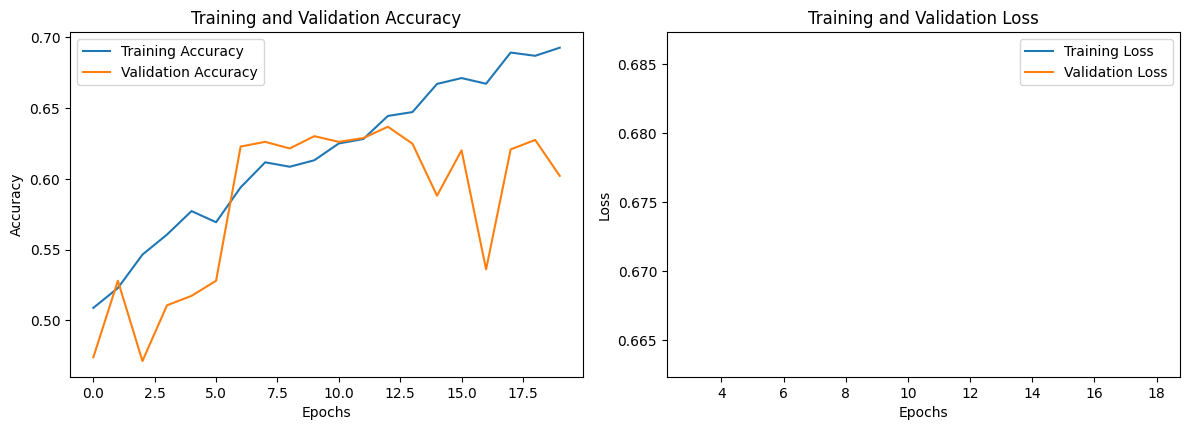

In [ ]:
# Plotting function
def plot_training_history(history):
    # Extract metrics from the history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_training_history(history)

In [ ]:
test_loss, test_accuracy, test_auc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

47/47 [==============================] - 25s 522ms/step - loss: nan - accuracy: 0.6213 - auc: 0.6642
Test Loss: nan
Test Accuracy: 0.6213333606719971
Test AUC: 0.6641841530799866


## Quantum Transformer

In [ ]:
class QuantumAttentionHead(Layer):
    def __init__(self, d_model):
        super(QuantumAttentionHead, self).__init__()
        self.d_model = d_model

        # Initialize quantum weights for the quantum circuit
        self.quantum_weights = self.add_weight(
            shape=(self.d_model * (self.d_model - 1) // 2,),
            initializer='random_normal',
            trainable=True,
            dtype=tf.float64,
            name='quantum_weights'
        )

        # Define the quantum device
        self.dev = qml.device("default.qubit.tf", wires=self.d_model)

        # Define the quantum circuit as a QNode
        @qml.qnode(self.dev, interface='tf', diff_method='backprop')
        def quantum_model_pyramid(q, k, weights):
            q = tf.cast(q, tf.float64)
            k = tf.cast(k, tf.float64)
            weights = tf.cast(weights, tf.float64)
            vector_loader(convert_array(q), wires=range(self.d_model))
            pyramid_circuit(weights, wires=range(self.d_model))
            vector_loader(convert_array(k), wires=range(self.d_model), is_x=False, is_conjugate=True)
            return qml.expval(qml.PauliZ(0))

        self.quantum_model_pyramid = quantum_model_pyramid

        # Define the final Dense layer to project the attention output
        self.dense = Dense(d_model, dtype=tf.float64)

    def call(self, queries, keys, values):
        """
        Forward pass for the Quantum Attention Head.

        Args:
            queries (Tensor): Shape (batch_size, num_queries, d_model)
            keys (Tensor): Shape (batch_size, num_keys, d_model)
            values (Tensor): Shape (batch_size, num_keys, d_model)

        Returns:
            Tuple[Tensor, Tensor]:
                - Output tensor after applying quantum attention and projection, shape (batch_size, num_queries, d_model)
                - Attention weights tensor, shape (batch_size, num_queries, num_keys)
        """
        # Ensure all inputs are float64
        queries = tf.cast(queries, tf.float64)  # Shape: (batch_size, num_queries, d_model)
        keys = tf.cast(keys, tf.float64)        # Shape: (batch_size, num_keys, d_model)
        values = tf.cast(values, tf.float64)    # Shape: (batch_size, num_keys, d_model)

        batch_size = tf.shape(queries)[0]
        num_queries = tf.shape(queries)[1]
        num_keys = tf.shape(keys)[1]
        d_model = self.d_model

        # Expand dimensions to prepare for broadcasting
        # queries_expanded: (batch_size, num_queries, 1, d_model)
        # keys_expanded: (batch_size, 1, num_keys, d_model)
        queries_expanded = tf.expand_dims(queries, axis=2)
        keys_expanded = tf.expand_dims(keys, axis=1)

        # Broadcast to (batch_size, num_queries, num_keys, d_model)
        queries_broadcast = tf.broadcast_to(queries_expanded, [batch_size, num_queries, num_keys, d_model])
        keys_broadcast = tf.broadcast_to(keys_expanded, [batch_size, num_queries, num_keys, d_model])

        # Stack queries and keys for mapping
        # stacked_inputs: (batch_size, num_queries, num_keys, 2, d_model)
        stacked_inputs = tf.stack([queries_broadcast, keys_broadcast], axis=-2)

        # Reshape to (batch_size * num_queries * num_keys, 2, d_model) for vectorized_map
        stacked_inputs_reshaped = tf.reshape(stacked_inputs, [batch_size * num_queries * num_keys, 2, d_model])

        # Compute attention scores using the quantum circuit
        def compute_attention_score(inputs):
            q, k = tf.unstack(inputs, num=2, axis=0)  # Each of shape (d_model,)
            return self.quantum_model_pyramid(q, k, self.quantum_weights)  # Returns a scalar

        # Vectorize the computation over all query-key pairs
        attention_scores = tf.vectorized_map(
            compute_attention_score,
            stacked_inputs_reshaped
        )  # Shape: (batch_size * num_queries * num_keys,)

        # Reshape back to (batch_size, num_queries, num_keys)
        attention_scores = tf.reshape(attention_scores, [batch_size, num_queries, num_keys])

        # Apply softmax to obtain attention weights
        attention_weights = tf.nn.softmax(attention_scores, axis=-1)  # Shape: (batch_size, num_queries, num_keys)

        # Multiply attention weights with values
        # values: (batch_size, num_keys, d_model)
        # attention_weights: (batch_size, num_queries, num_keys)
        # Need to perform batched matrix multiplication
        weighted_values = tf.matmul(attention_weights, values)  # Shape: (batch_size, num_queries, d_model)

        # Pass through the final Dense layer
        final_output = self.dense(weighted_values)  # Shape: (batch_size, num_queries, d_model)

        return final_output, attention_weights

In [ ]:
class Block(Layer):
    def __init__(self, d_model, dropout_rate=0.1):
        super(Block, self).__init__()
        self.norm1 = LayerNormalization(epsilon=1e-6, dtype=tf.float64)
        self.attn = QuantumAttentionHead(d_model=d_model)
        self.norm2 = LayerNormalization(epsilon=1e-6, dtype=tf.float64)
        self.mlp = MLP(hidden_features=d_model * 2, out_features=d_model, dropout_rate=dropout_rate)

    def call(self, x):
        # x shape: (batch_size, num_patches, d_model)
        # Normalize the input
        x_norm = self.norm1(x)
        # Apply Quantum Attention
        attn_output, attn_weights = self.attn(x_norm, x_norm, x_norm)  #(q, k, v) = (x_norm, x_norm, x_norm)
        # Residual connection
        x = Add()([attn_output, x])
        # Second normalization
        x_norm = self.norm2(x)
        # Apply MLP
        mlp_output = self.mlp(x_norm)
        # Second residual connection
        x = Add()([mlp_output, x])
        return x

In [ ]:
class TransformerEncoder(Layer):
    def __init__(self, projection_dim, num_blocks=1, dropout_rate=0.2):
        super(TransformerEncoder, self).__init__()
        # Define blocks of transformer encoder
        self.blocks = [Block(projection_dim, dropout_rate) for _ in range(num_blocks)]
        # Final layer normalization
        self.norm = LayerNormalization(epsilon=1e-6)
        # Final dropout layer
        self.dropout = Dropout(dropout_rate)

    def call(self, x):
        # Pass input through each block
        for block in self.blocks:
            x = block(x)
        # Apply final layer normalization
        x = self.norm(x)
        # Apply final dropout
        y = self.dropout(x)
        return y

In [ ]:
# Define the QuantumVisionTransformer class with the updated train_step needed to handle nan values
class QuantumVisionTransformer(tf.keras.Model):
    def train_step(self, data):
        x, y = data  # Unpack the data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        gradients = tape.gradient(loss, self.trainable_variables)

        # Sanitize gradients: replace NaNs with zeros
        sanitized_gradients = []
        for grad in gradients:
            if grad is not None:
                # Replace NaNs with zeros
                grad = tf.where(tf.math.is_nan(grad), tf.zeros_like(grad), grad)
            sanitized_gradients.append(grad)

        # Apply the sanitized gradients
        self.optimizer.apply_gradients(zip(sanitized_gradients, self.trainable_variables))

        #make weights that are nan 0
        for var in self.trainable_variables:
            # Create a mask where NaNs are present
            nan_mask = tf.math.is_nan(var)
            # Replace NaNs with zeros
            sanitized_var = tf.where(nan_mask, tf.zeros_like(var), var)
            # Assign the sanitized variable back to the model
            var.assign(sanitized_var)
        # Update metrics
        self.compiled_metrics.update_state(y, y_pred)

        # Return a dictionary of metric results
        return {m.name: m.result() for m in self.metrics}

In [ ]:
def create_QuantumVisionTransformer(num_patches=25, projection_dim=8, input_shape=(125,125,3)):
    inputs = Input(shape=input_shape)
    # Patch extractor
    patches = PatchExtractor()(inputs)
    # Patch encoder
    patches_embed = PatchEncoder(num_patches, projection_dim)(patches)
    # Transformer encoder
    representation = TransformerEncoder(projection_dim)(patches_embed)
    representation = GlobalAveragePooling1D()(representation)
    # MLP to classify outputs
    logits = Dense(1, activation='sigmoid')(representation)
    # Create custom model
    model = QuantumVisionTransformer(inputs, logits)
    return model

model = create_QuantumVisionTransformer()
model.summary()

Model: "quantum_vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 125, 125, 3)]     0         
                                                                 
 patch_extractor_1 (PatchEx  (None, None, 1875)        0         
 tractor)                                                        
                                                                 
 patch_encoder_1 (PatchEnco  (None, 26, 8)             15224     
 der)                                                            
                                                                 
 transformer_encoder (Trans  (None, 26, 8)             428       
 formerEncoder)                                                  
                                                                 
 global_average_pooling1d (  (None, 8)                 0         
 GlobalAveragePooling1D)                

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),  # Default learning rate for Adam is 0.001
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', tf.keras.metrics.AUC(name='auc')]  # Add AUC to the list of metrics
)

In [23]:
history = model.fit(
    train_images, train_labels,
    epochs=20,
    batch_size=32,
    validation_data=(validation_images, validation_labels)
)

Epoch 1/20


219/219 [==============================] - 2678s 12s/step - loss: 0.6830 - accuracy: 0.5516 - auc: 0.5766 - val_loss: 0.6560 - val_accuracy: 0.6273 - val_auc: 0.6656
Epoch 2/20
219/219 [==============================] - 2662s 12s/step - loss: 0.6263 - accuracy: 0.6650 - auc: 0.7075 - val_loss: 0.6666 - val_accuracy: 0.6207 - val_auc: 0.6784
Epoch 3/20
219/219 [==============================] - 2680s 12s/step - loss: 0.5797 - accuracy: 0.7096 - auc: 0.7651 - val_loss: 0.6709 - val_accuracy: 0.6267 - val_auc: 0.6889
Epoch 4/20
219/219 [==============================] - 2683s 12s/step - loss: 0.5380 - accuracy: 0.7406 - auc: 0.8035 - val_loss: 0.6629 - val_accuracy: 0.6440 - val_auc: 0.7030
Epoch 5/20
219/219 [==============================] - 2688s 12s/step - loss: 0.5005 - accuracy: 0.7671 - auc: 0.8333 - val_loss: 0.7127 - val_accuracy: 0.6307 - val_auc: 0.6961
Epoch 6/20
  1/219 [..............................] - ETA: 40:34 - loss: 0.4837 - accuracy: 0.7812 - auc: 0.8274

KeyboardInterrupt: 

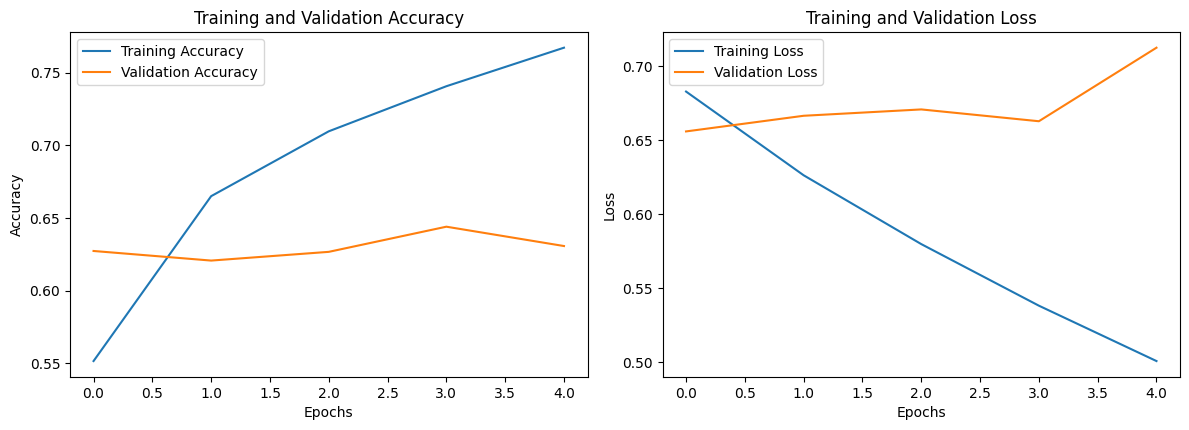

In [28]:
# Plotting function
def plot_training_history():
    # Extract metrics from the history object
    acc = [0.5516, 0.6650, 0.7096, 0.7406, 0.7671]#history.history['accuracy']
    val_acc = [0.6273, 0.6207, 0.6267, 0.6440, 0.6307]#history.history['val_accuracy']
    loss = [0.6830, 0.6263, 0.5797, 0.5380, 0.5005] #history.history['loss']
    val_loss = [0.6560, 0.6666, 0.6709, 0.6629, 0.7127]#history.history['val_loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 8))

    # Plot Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(2, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

# Call the function to plot the metrics
plot_training_history()

In [25]:
test_loss, test_accuracy, test_auc = model.evaluate(test_images, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")
print(f"Test AUC: {test_auc}")

47/47 [==============================] - 243s 5s/step - loss: 0.7364 - accuracy: 0.6253 - auc: 0.6824
Test Loss: 0.7363588809967041
Test Accuracy: 0.625333309173584
Test AUC: 0.682394802570343
